In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.filters import gaussian, window
import cv2
import inspect
import math
import torch as tc
#from scipy.stats.distributions import chi2

In [2]:
import torch
def LinearSpline3D(pts,x,device='cpu',scale=[1.0, 1.0, 1.0],return_jac=False):
    scale=torch.tensor(scale,dtype=torch.float32,device=device)
    t_idx=pts.mul(1/scale).floor()
    #t_idx.detach()
    p=torch.arange(pts.size(0))
    #print(p)
    t=pts.mul(1/scale)-t_idx
    #make a cube of 2x2x2 of ones as a helper for converting indices
    ones4=torch.ones([2,2,2],dtype=torch.int32,device=device)
    #make a array of ones as a helper for converting indices
    onesp=torch.ones(t.size(0),dtype=torch.int32,device=device)
    #make a cube of 2x2x2 of indices (0-origin) as a helper for converting indices
    stride_x, stride_y, stride_z=torch.meshgrid([torch.arange(0,2,device=device), torch.arange(0,2,device=device), torch.arange(0,2,device=device)])
    #compute/transform the indices to the flatten domain
    t_idx=t_idx.flatten()
    indices=(torch.clamp(torch.einsum('a,bcd->abcd',t_idx[3*p],ones4)+torch.einsum('a,bcd->abcd',onesp,stride_x.int()),0,x.shape[1]-1)*(x.shape[2]*x.shape[3])).long()
    indices=indices+(torch.clamp(torch.einsum('a,bcd->abcd',t_idx[3*p+1],ones4)+torch.einsum('a,bcd->abcd',onesp,stride_y.int()),0,x.shape[2]-1)*(x.shape[3])).long()
    indices=indices+(torch.clamp(torch.einsum('a,bcd->abcd',t_idx[3*p+2],ones4)+torch.einsum('a,bcd->abcd',onesp,stride_z.int()),0,x.shape[3]-1)).long()
    #print(indices,indices1,indices2,indices3,"All: ",indices1+indices2+indices3,"2+3: ",indices2+indices3,"1+2: ",indices1+indices2)
    #the parameter vector for the spline (1D)
    y=torch.stack([1-t.flatten(), t.flatten()],dim=1) 
    #compute the element-wise kroenecker products 
    w=torch.sum(torch.einsum('ab,ac,ad->abcd',y[3*p,:],y[3*p+1,:],y[3*p+2,:])*x.flatten(start_dim=1)[:,indices.long()],dim=[2,3,4])
    # derivatives
    #the parameter vector for the derivative spline (1D)
    jac=None
    if(return_jac):
        dy=torch.stack([t.flatten().clone()*0-1, t.flatten().clone()*0+1],dim=1)
        wx=torch.sum(torch.einsum('ab,ac,ad->abcd',dy[3*p,:],y[3*p+1,:],y[3*p+2,:])*x.flatten(start_dim=1)[:,indices],dim=[2,3,4])
        wy=torch.sum(torch.einsum('ab,ac,ad->abcd',y[3*p,:],dy[3*p+1,:],y[3*p+2,:])*x.flatten(start_dim=1)[:,indices],dim=[2,3,4])
        wz=torch.sum(torch.einsum('ab,ac,ad->abcd',y[3*p,:],y[3*p+1,:],dy[3*p+2,:])*x.flatten(start_dim=1)[:,indices],dim=[2,3,4])
        #construct the array of jacobians
        jac=torch.stack([wx.t()/scale[0],wy.t()/scale[1],wz.t()/scale[2]],dim=2)
    return w,jac
def LinearSpline2D(pts,x,device='cpu',scale=[1.0, 1.0],return_jac=False):
    pts=torch.cat([pts[:,1].view(pts.shape[0],1)*0,pts],dim=1)
    return LinearSpline3D(pts, x.view(1,x.shape[0],x.shape[1],x.shape[2]),device)

def Histogram_LOR_LIN(vals, device='cpu'):
    rangeh = torch.ceil(vals.max() - vals.min()).long() + 4
    t_idx = vals.floor().long() + 2
    p = torch.arange(vals.size(0))
    t = vals.double() + 2 - t_idx
    # print("rangeh: ",rangeh, '\n')
    ones4 = torch.ones([2, 2], dtype=torch.int32, device=device)
    onesp = torch.ones(t.size(0), dtype=torch.int32, device=device)
    stride_x, stride_y = torch.meshgrid([torch.arange(0, 2, device=device) - 1, torch.arange(0, 2, device=device) - 1])
    t_idx = t_idx.flatten()
    indices = torch.einsum('a,bc->abc', t_idx[2 * p], ones4) * (rangeh)
    indices += torch.einsum('a,bc->abc', onesp, stride_x) * rangeh
    indices += torch.einsum('a,bc->abc', t_idx[2 * p + 1], ones4)
    indices += torch.einsum('a,bc->abc', onesp, stride_y)
    y = torch.stack([1 - t.flatten(), t.flatten()], dim=1)
    res = (torch.einsum('ab,ac->abc', y[2 * p, :], y[2 * p + 1, :]))
    # print("res: ",res.sum(),res.shape,indices.shape)
    sort_res, nid = torch.sort(indices.flatten())
    nres = res.flatten()[nid.flatten()]
    v, ids = sort_res.flatten().unique_consecutive(return_counts=True)

    val = torch.split(nres.flatten(), ids.tolist());
    hist = torch.zeros(v.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(val):
        hist[index] = value.sum()
    return hist[hist > 0], (v.flatten()%rangeh)[hist > 0],((v.flatten()/rangeh).int())[hist > 0]
def Histogram2D(vals, device='cpu'):
    rangeh = torch.ceil(vals.max() - vals.min()).long() + 4
    t_idx = vals.floor().long() + 2
    p = torch.arange(vals.size(0))
    t = vals.double() + 2 - t_idx
    # print("rangeh: ",rangeh, '\n')
    ones4 = torch.ones([2, 2], dtype=torch.int32, device=device)
    onesp = torch.ones(t.size(0), dtype=torch.int32, device=device)
    stride_x, stride_y = torch.meshgrid([torch.arange(0, 2, device=device) - 1, torch.arange(0, 2, device=device) - 1])
    t_idx = t_idx.flatten()
    indices = torch.einsum('a,bc->abc', t_idx[2 * p], ones4) * (rangeh)
    indices += torch.einsum('a,bc->abc', onesp, stride_x) * rangeh
    indices += torch.einsum('a,bc->abc', t_idx[2 * p + 1], ones4)
    indices += torch.einsum('a,bc->abc', onesp, stride_y)
    y = torch.stack([1 - t.flatten(), t.flatten()], dim=1)
    res = (torch.einsum('ab,ac->abc', y[2 * p, :], y[2 * p + 1, :]))
    # print("res: ",res.sum(),res.shape,indices.shape)
    sort_res, nid = torch.sort(indices.flatten())
    nres = res.flatten()[nid.flatten()]
    v, ids = sort_res.flatten().unique_consecutive(return_counts=True)
    val = torch.split(nres.flatten(), ids.tolist());
    hist = torch.zeros(v.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(val):
        hist[index] = value.sum()
    sort_res, nid = torch.sort(v.flatten() % rangeh)
    nres = hist.flatten()[nid.flatten()]
    va, ids = sort_res.flatten().unique_consecutive(return_counts=True)
    vala = torch.split(nres.flatten(), ids.tolist());
    hist_a = torch.zeros(va.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(vala):
        hist_a[index] = value.sum()
    sort_res, nid = torch.sort((v.flatten() / rangeh).int())
    nres = hist.flatten()[nid.flatten()]
    vb, ids = sort_res.flatten().unique_consecutive(return_counts=True)
    valb = torch.split(nres.flatten(), ids.tolist());
    hist_b = torch.zeros(vb.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(valb):
        hist_b[index] = value.sum()
    return hist[hist > 0], hist_a[hist_a > 0], hist_b[hist_b > 0]

def SSD(x,device='cpu'):
    return torch.sum((x[:,0]-x[:,1])**2)

In [10]:
# from PIL import Image

# imA = Image.open('I74.JPG')
# imA = imA.resize((259,195))
# imA = np.asarray(imA)
# imB = Image.open('I75.JPG')
# imB = imB.resize((259,195))
# imB = np.asarray(imB)
# imC = plt.imread('white_noise.png')
# imA = torch.tensor(cv2.cvtColor(imA,cv2.COLOR_RGB2GRAY).astype(np.float64)).numpy()
# imB = torch.tensor(cv2.cvtColor(imB,cv2.COLOR_RGB2GRAY).astype(np.float64)).numpy()
# imC = torch.tensor(cv2.cvtColor(imC,cv2.COLOR_RGB2GRAY).astype(np.float64)).numpy()

imA = cv2.imread('I74.JPG')
imA = cv2.cvtColor(imA, cv2.COLOR_BGR2GRAY)
imB = cv2.imread('I75.JPG')
imB = cv2.cvtColor(imB, cv2.COLOR_BGR2GRAY)

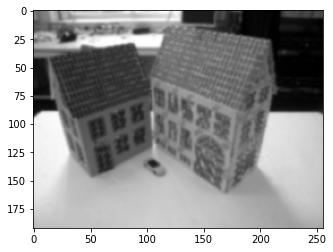

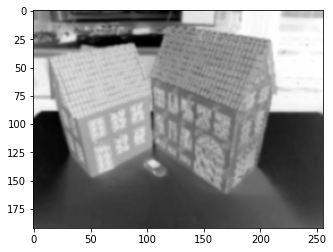

In [19]:
aspectA = imA.shape[0]/imA.shape[1]
aspectB = imB.shape[0]/imB.shape[1]
imAr = cv2.resize(imA,(256,int(256*aspectA)))
imBr = cv2.resize(imA*-1,(256,int(256*aspectA)))

imAr = skimage.filters.gaussian(imAr,1)
imBr = skimage.filters.gaussian(imBr,1)

plt.imshow(imAr,cmap='gray')
plt.show()
plt.imshow(imBr,cmap='gray')

In [ ]:
def linearPipeline(imA,imB,samplingSpace):
    intsA = imA[::samplingSpace,::samplingSpace].flatten()
    intsB = imB[::samplingSpace,::samplingSpace].flatten()
    samples = np.array([intsA,intsB]).T * 255
    print(samples.shape)
    samples = torch.from_numpy(samples.astype(np.float64))
    histVals, x, y = Histogram_LOR_LIN(samples)
    print(f'Number of values: {len(histVals)}')

    # hist = np.zeros((258,258))
    # for v,x,y in zip(histVals,x,y):
    #     hist[y,x] = v

    # plt.imshow(hist)
    return histVals, x, y

def nonLinearPipeline(imA,imB,samplingSpace):
    intsA = imA[::samplingSpace,::samplingSpace].flatten()
    intsB = imB[::samplingSpace,::samplingSpace].flatten()
    samples = np.array([intsA,intsB]).T * 255
    samples = torch.from_numpy(samples.astype(np.float64))
    joined, histA, histB = Histogram2D(samples)
    print(f'Number of values: {len(joined)}')
    print(f'len A: {len(histA)}\nlen B: {len(histB)}')
    return joined, histA, histB

### P-norm

In [ ]:
h,x,y = linearPipeline(imA,imA,500)

(24, 2)
Number of values: 94


In [5]:
def pnorm(h,x,y,p):
    return torch.sum(h*(x-y)**p)**(1/p)

In [ ]:
print(pnorm(h,x,y,2))

tensor(2.6337, dtype=torch.float64)


### Cross correlation

In [ ]:
j,a,b = nonLinearPipeline(imA,imA,100)

Number of values: 658
len A: 244
len B: 244


In [6]:
def NCC(h,i,j):
    #h, i, j = Histogram_LOR_LIN(x, device)
    h=h/h.sum()
    mu_i=(h*i).sum()
    mu_j=(h*j).sum()
    #std_i = ( h *torch.sqrt((i - mu_i)**2)).sum()
    std_i = torch.sqrt((h*i**2).sum()-mu_i**2)
    std_j = torch.sqrt((h * j ** 2).sum() - mu_j ** 2)

    return torch.sum(h*(i-mu_i)*(j-mu_j))/(std_i*std_j)

In [55]:
def NCC(j,a,b):
    aZ = torch.zeros(256-len(a))
    bZ = torch.zeros(256-len(b))
    a = torch.cat((a,aZ))
    b = torch.cat((b,bZ))
    s = torch.sum(a*b)
    stdA = torch.sqrt(torch.sum(a**2))
    stdB = torch.sqrt(torch.sum(b**2))

    return s/(stdA*stdB)

In [ ]:
print(NCC(a,b))

tensor(1., dtype=torch.float64)


### Normalized Mutual Information

In [7]:
def NMI(j,a,b):
    hij = tc.sum(-j/j.sum()*tc.log(j/j.sum()))
    hi = tc.sum(-a/a.sum()*tc.log(a/a.sum()))
    hj = tc.sum(-b/b.sum()*tc.log(b/b.sum()))
    return (hi+hj)/hij

In [73]:
def NMI(j,a,b):
    na = a/torch.sum(a)
    nb = b/torch.sum(b)
    nj = j/torch.sum(j)
    Ha = -torch.sum(na*torch.log(na))
    Hb = -torch.sum(nb*torch.log(nb))
    Hab = -torch.sum(nj*torch.log(nj))
    return (Ha+Hb)/Hab

In [ ]:
print(NMI(j,a,b))

### Mutual Information

In [8]:
def MI(j,a,b):
    hij = tc.sum(-j/j.sum()*tc.log(j/j.sum()))
    hi = tc.sum(-a/a.sum()*tc.log(a/a.sum()))
    hj = tc.sum(-b/b.sum()*tc.log(b/b.sum()))
    return hi+hj-hij

In [ ]:
def MI(j,a,b):
    na = a/torch.sum(a)
    nb = b/torch.sum(b)
    nj = j/torch.sum(j)
    Ha = torch.sum(na*torch.log(na))
    Hb = torch.sum(nb*torch.log(nb))
    Hab = torch.sum(nj*torch.log(nj))
    return Ha+Hb-Hab

In [ ]:
print(MI(j,a,b))

tensor(-3.2484)


# Similarity measures

### NMI

 progress: 100.0%

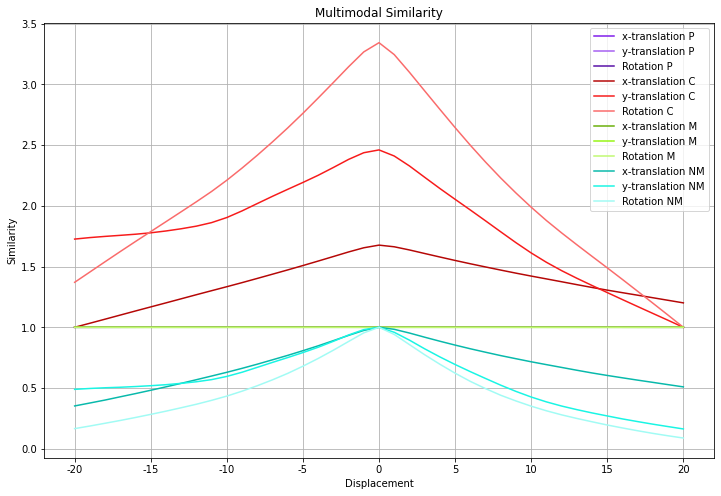

In [20]:
gridSizeX = imAr.shape[0]
gridSizeY = imAr.shape[1]
sizeX = imAr.shape[0]
sizeY = imAr.shape[1]
padSize = 20
sim_func = MI
img1 = tc.from_numpy(imAr)
img2 = tc.from_numpy(np.pad(imBr,((0,0),(padSize,padSize))))
img3 = tc.from_numpy(np.pad(imBr,((padSize,padSize),(0,0))))
img4 = np.array(imBr)


x_coords,y_coords = tc.meshgrid([tc.arange(0,gridSizeX),tc.arange(0,gridSizeY)])
pts = tc.stack([x_coords.flatten(),y_coords.flatten()],dim=1)
samp_1,_ = LinearSpline2D(pts,img1.view(1,sizeX,sizeY))

#similarity = []
res = []
samples_x = np.arange(0,padSize*2+1)
samples_y = np.arange(0,padSize*2+1)
samples_r = np.arange(-padSize,padSize+1)
for sim_func in [pnorm,NCC,NMI,MI]:
    similarity = []
    for (i,_),xt,yt,r in zip(enumerate(samples_x),samples_x,samples_y,samples_r):
        pts_x = pts + tc.stack([tc.zeros(len(x_coords.flatten())),tc.zeros(len(y_coords.flatten()))+xt],dim=1)
        pts_y = pts + tc.stack([tc.zeros(len(x_coords.flatten()))+yt,tc.zeros(len(y_coords.flatten()))],dim=1)

        img4 = np.array(imBr)
        (h, w) = img4.shape
        (cX, cY) = (w // 2, h // 2) 
        R = cv2.getRotationMatrix2D((cX, cY), r, 1.0)
        rotated = cv2.warpAffine(img4, R, (w, h))
        img4 = tc.from_numpy(rotated)

        samp_x,_ = LinearSpline2D(pts_x,img2.view(1,sizeX,sizeY+padSize*2))
        samp_y,_ = LinearSpline2D(pts_y,img3.view(1,sizeX+padSize*2,sizeY))
        samp_r,_ = LinearSpline2D(pts,img4.view(1,sizeX,sizeY))

        pair_x = tc.stack([samp_x.flatten(),samp_1.flatten()],dim=1)
        pair_y = tc.stack([samp_y.flatten(),samp_1.flatten()],dim=1)
        pair_r = tc.stack([samp_r.flatten(),samp_1.flatten()],dim=1)

        if (sim_func == pnorm):
            jx,ax,bx = Histogram_LOR_LIN(pair_x)
            jy,ay,by = Histogram_LOR_LIN(pair_y)
            jr,ar,br = Histogram_LOR_LIN(pair_r)
            similarity.append([sim_func(jx,ax,bx,2),sim_func(jy,ay,by,2),sim_func(jr,ar,br,2)])
        elif (sim_func == NCC):
            jx,ax,bx = Histogram_LOR_LIN(pair_x)
            jy,ay,by = Histogram_LOR_LIN(pair_y)
            jr,ar,br = Histogram_LOR_LIN(pair_r)
            similarity.append([sim_func(jx,ax,bx),sim_func(jy,ay,by),sim_func(jr,ar,br)])
        else:
            jx,ax,bx = Histogram2D(pair_x)
            jy,ay,by = Histogram2D(pair_y)
            jr,ar,br = Histogram2D(pair_r)
            similarity.append([sim_func(jx,ax,bx),sim_func(jy,ay,by),sim_func(jr,ar,br)])
        print(f"\r progress: {round(((i+1)/len(samples_x)*100),2)}%", end="")
    res.append(similarity)
    
#similarity = np.array(similarity)
res = np.array(res)
dividers = np.array([[np.min(res[0,:,0]), np.min(res[0,:,1]),np.min(res[0,:,2])],
                     [np.max(res[1,:,0]), np.max(res[1,:,1]),np.max(res[1,:,2])],
                     [np.max(res[2,:,0]), np.max(res[2,:,1]),np.max(res[2,:,2])],
                     [np.max(res[3,:,0]), np.max(res[3,:,1]),np.max(res[3,:,2])]])
dividers = np.tile(dividers,(len(samples_x),)).reshape((4,len(samples_x),3))
res = res / dividers
#print(res)
# print(res.shape)

plt.figure(figsize=(12,8))
# plt.plot(samples_x,similarity[:,0],label='x-translation')
# plt.plot(samples_y,similarity[:,1],label='y-translation')
# plt.plot(samples_x,similarity[:,2],label='Rotation')
plt.plot(samples_x,res[0,:,0],label='x-translation P',color=('#7f1beb'))
plt.plot(samples_y,res[0,:,1],label='y-translation P',color=('#a55ff1'))
plt.plot(samples_x,res[0,:,2],label='Rotation P',color=('#570ea6'))
plt.plot(samples_x,res[1,:,0],label='x-translation C',color=('#b50706'))
plt.plot(samples_y,res[1,:,1],label='y-translation C',color=('#f71b1b'))
plt.plot(samples_x,res[1,:,2],label='Rotation C',color=('#fa6b6b'))
plt.plot(samples_x,res[2,:,0],label='x-translation M',color=('#69af08'))
plt.plot(samples_y,res[2,:,1],label='y-translation M',color=('#96f512'))
plt.plot(samples_x,res[2,:,2],label='Rotation M',color=('#c0f971'))
plt.plot(samples_x,res[3,:,0],label='x-translation NM',color=('#08b9ab'))
plt.plot(samples_y,res[3,:,1],label='y-translation NM',color=('#19f5e4'))
plt.plot(samples_x,res[3,:,2],label='Rotation NM',color=('#a1fbf4'))
plt.legend()
plt.grid()
plt.xlabel('Displacement')
plt.ylabel('Similarity')
plt.title('Multimodal Similarity')
plt.xticks(np.arange(0,padSize*2+1,5),np.arange(-padSize,padSize+1,5))

#plt.savefig(f'Latex/Materials/objectSimilarity.png', dpi=250, bbox_inches = 'tight', pad_inches = 0)
plt.show()

([<matplotlib.axis.XTick at 0x7f96c639b3c8>,
 [Text(0, 0, '-20'),
  Text(0, 0, '-15'),
  Text(0, 0, '-10'),
  Text(0, 0, '-5'),
  Text(0, 0, '0'),
  Text(0, 0, '5'),
  Text(0, 0, '10'),
  Text(0, 0, '15'),
  Text(0, 0, '20')])

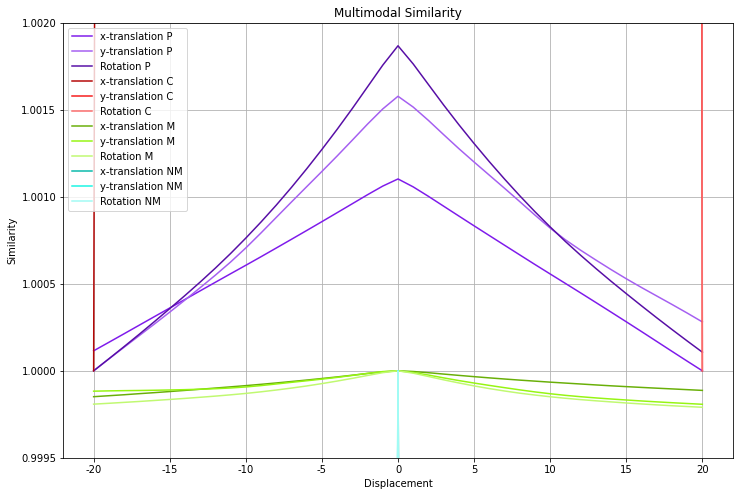

In [29]:
plt.figure(figsize=(12,8))
# plt.plot(samples_x,similarity[:,0],label='x-translation')
# plt.plot(samples_y,similarity[:,1],label='y-translation')
# plt.plot(samples_x,similarity[:,2],label='Rotation')
plt.plot(samples_x,res[0,:,0],label='x-translation P',color=('#7f1beb'))
plt.plot(samples_y,res[0,:,1],label='y-translation P',color=('#a55ff1'))
plt.plot(samples_x,res[0,:,2],label='Rotation P',color=('#570ea6'))
plt.plot(samples_x,res[1,:,0],label='x-translation C',color=('#b50706'))
plt.plot(samples_y,res[1,:,1],label='y-translation C',color=('#f71b1b'))
plt.plot(samples_x,res[1,:,2],label='Rotation C',color=('#fa6b6b'))
plt.plot(samples_x,res[2,:,0],label='x-translation M',color=('#69af08'))
plt.plot(samples_y,res[2,:,1],label='y-translation M',color=('#96f512'))
plt.plot(samples_x,res[2,:,2],label='Rotation M',color=('#c0f971'))
plt.plot(samples_x,res[3,:,0],label='x-translation NM',color=('#08b9ab'))
plt.plot(samples_y,res[3,:,1],label='y-translation NM',color=('#19f5e4'))
plt.plot(samples_x,res[3,:,2],label='Rotation NM',color=('#a1fbf4'))
plt.legend()
plt.grid()
plt.xlabel('Displacement')
plt.ylabel('Similarity')
plt.title('Multimodal Similarity')
plt.ylim(0.9995,1.002)
plt.xticks(np.arange(0,padSize*2+1,5),np.arange(-padSize,padSize+1,5))

### x-translation

In [70]:
padSize = 50
img1 = tc.from_numpy(imAr)
img2 = tc.from_numpy(np.pad(imBr,((0,0),(padSize,padSize))))

x_coords,y_coords = tc.meshgrid([tc.arange(0,gridSize),tc.arange(0,gridSize)])
pts = tc.stack([x_coords.flatten(),y_coords.flatten()],dim=1)
samp_1,_ = LinearSpline2D(pts,img1.view(1,size,size))

similarity = []
samples_x = np.arange(0,padSize*2+1)
for k in samples_x:
    pts2 = pts + tc.stack([tc.zeros(len(x_coords.flatten())),tc.zeros(len(y_coords.flatten()))+k],dim=1)
    samp_2,_ = LinearSpline2D(pts2,img2.view(1,size,size+padSize*2))
    
    pair = tc.stack([samp_2.flatten(),samp_1.flatten()],dim=1)
    
    h,x,y = Histogram_LOR_LIN(pair)
    j,a,b = Histogram2D(pair)
    
    similarity.append([pnorm(h,x,y,2), NCC(0,a,b), NMI(j,a,b), MI(j,a,b)])
#     plt.figure()
#     plt.imshow(samp_2.view(size,size))
similarity = np.array(similarity)
#similarity /= np.array([176,1,2,1])

plt.figure()
#plt.plot(samples_x,similarity[:,0],label='p-norm')
#plt.plot(samples_x,similarity[:,1],label='NCC')
plt.plot(samples_x,similarity[:,2],label='NMI')
#plt.plot(samples_x,similarity[:,3],label='MI')
plt.legend()
plt.xticks(np.arange(0,padSize*2+1,5),np.arange(-padSize,padSize+1,5))
plt.show()

NameError: name 'gridSize' is not defined

### y-translation

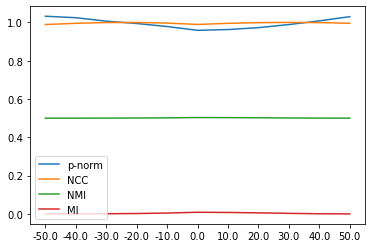

In [123]:
padSize = 50
img1 = tc.from_numpy(imAr)
img2 = tc.from_numpy(np.pad(imBr,((padSize,padSize),(0,0))))

x_coords,y_coords = tc.meshgrid([tc.arange(0,gridSize),tc.arange(0,gridSize)])
pts = tc.stack([x_coords.flatten(),y_coords.flatten()],dim=1)
samp_1,_ = LinearSpline2D(pts,img1.view(1,size,size))

similarity = []
samples_x = np.arange(0,padSize*2+1)
for k in samples_x:
    pts2 = pts + tc.stack([tc.zeros(len(x_coords.flatten()))+k,tc.zeros(len(y_coords.flatten()))],dim=1)
    samp_2,_ = LinearSpline2D(pts2,img2.view(1,size+padSize*2,size))
    
    pair = tc.stack([samp_2.flatten(),samp_1.flatten()],dim=1)
    
    h,x,y = Histogram_LOR_LIN(pair)
    j,a,b = Histogram2D(pair)
    
    similarity.append([pnorm(h,x,y,2), NCC(a,b), NMI(j,a,b), MI(j,a,b)])
#     plt.figure()
#     plt.imshow(samp_2.view(size,size))
similarity = np.array(similarity)
similarity /= np.array([176,1,2,1])

plt.figure()
plt.plot(samples_x,similarity[:,0],label='p-norm')
plt.plot(samples_x,similarity[:,1],label='NCC')
plt.plot(samples_x,similarity[:,2],label='NMI')
plt.plot(samples_x,similarity[:,3],label='MI')
plt.legend()
plt.xticks(np.arange(0,padSize*2+1,5),np.arange(-padSize,padSize+1,5))
plt.show()

### Rotation

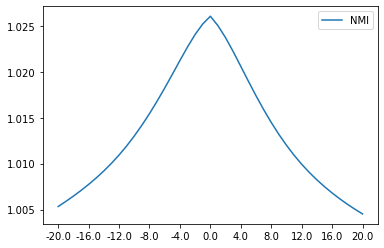

In [172]:
padSize = 50
img1 = tc.from_numpy(imAr)
img2 = np.array(imBr)

x_coords,y_coords = tc.meshgrid([tc.arange(0,gridSize),tc.arange(0,gridSize)])
pts = tc.stack([x_coords.flatten(),y_coords.flatten()],dim=1)
samp_1,_ = LinearSpline2D(pts,img1.view(1,size,size))

similarity = []
samples_x = np.arange(20,-21,-1)
for k in samples_x:
    img2 = np.array(imBr)
    (h, w) = img2.shape
    (cX, cY) = (w // 2, h // 2) 
    R = cv2.getRotationMatrix2D((cX, cY), k, 1.0)
    rotated = cv2.warpAffine(img2, R, (w, h))
    img2 = tc.from_numpy(rotated)
    
    samp_2,_ = LinearSpline2D(pts,img2.view(1,size,size))
    
    pair = tc.stack([samp_2.flatten(),samp_1.flatten()],dim=1)
    
    h,x,y = Histogram_LOR_LIN(pair)
    j,a,b = Histogram2D(pair)
    
    similarity.append([pnorm(h,x,y,2), NCC(a,b), NMI(j,a,b), MI(j,a,b)])
#     plt.figure()
#     plt.imshow(samp_2.view(size,size))
similarity = np.array(similarity)
#similarity /= np.array([176,1,2,1])

plt.figure()
#plt.plot(samples_x,similarity[:,0],label='p-norm')
#plt.plot(samples_x,similarity[:,1],label='NCC')
plt.plot(samples_x,similarity[:,2],label='NMI')
#plt.plot(samples_x,similarity[:,3],label='MI')
plt.legend()
plt.xticks(np.linspace(20,-20,11),np.linspace(20,-20,11))
plt.show()

# Registration

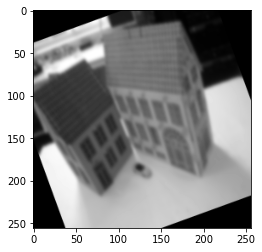

In [104]:
nIm = imAr
(h, w) = nIm.shape
(cX, cY) = (w // 2, h // 2) 
R = cv2.getRotationMatrix2D((cX, cY), 20, 1.0)
rotated = cv2.warpAffine(nIm, R, (w, h))
plt.imshow(rotated,cmap='gray')

In [75]:
def registration(imA,imB,samplingSpace):
    imA = tc.from_numpy(imAr)
    imB = tc.from_numpy(imBr)

    sampleSize = imA.flatten()[::samplingSpace]
    print(sampleSize.shape)
    
    theta = tc.tensor([.0],requires_grad=True)
    tx = tc.tensor([3.],requires_grad=True)
    ty = tc.tensor([3.],requires_grad=True)

    t_lr = 100.0
    r_lr = 4.
    opt = 1.0
    dot = None

    # Vector form of image
    ar = np.arange(0,imA.shape[1])
    x = np.array([ar for _ in range(imA.shape[0])]).flatten()
    n = np.array([])
    for i in range(imA.shape[0]):
        t = np.full((imA.shape[1]),i)
        n = np.append(n,t)
    y = n.flatten()
    vForm = tc.from_numpy(np.stack((x,y,np.ones_like(x)),axis=0)).float()
    errs = []

    for i in range(200):
        P = tc.cat((tc.cos(theta), -tc.sin(theta), tx, tc.sin(theta), tc.cos(theta), ty, tc.tensor([0.]),tc.tensor([0.]),tc.tensor([1.]))).reshape((3,3))


        # Rotation and translation
        transMtx = tc.tensor([[imA.shape[0]//2], [imA.shape[1]//2], [0]])
        t = P@(vForm-transMtx)+transMtx
        
        #idx = []
        # for j in range(t.shape[1]):
        #     if not (-1 < t[0,j] < 256 and -1 < t[1,j] < 256):
        #         idx.append(j)
        
        mask = tc.logical_and(tc.logical_and(t[0,:] < 256, t[0,:] > -1), tc.logical_and(t[1,:] < 256, t[1,:] > -1))
        
        w,_ = LinearSpline2D(t[:2,:].T,imB.view(1,imB.shape[0],imB.shape[1]))
        w = w.reshape((-1,))
        # if (len(idx) != 0):
        #     w.index_fill_(0,tc.tensor(idx),0)
        w[tc.logical_not(mask)] = 0.0
        w = w[::samplingSpace]
        im_samples,_ = LinearSpline2D(vForm[:2,:].T,imB.view(1,imB.shape[0],imB.shape[1]))
        im_samples = im_samples.reshape((-1,))
        im_samples = im_samples[::samplingSpace]
        samples = tc.stack([w,im_samples]).T

        j, a, b = Histogram2D(samples)
        #h,x,y = Histogram_LOR_LIN(samples)

        #Y = pnorm(h,x,y,2)
        #Y = NCC(a,b)
        Y = NMI(j,a,b)
        print(f'\riter, {i}, err, {Y.data}, thetha, {theta.data}', end='')
        errs.append(Y.data)
        Y.retain_grad()
        
        Y.backward()
        
        #print('theta.grad', theta.grad, 'tx.grad', tx.grad, 'ty.grad', ty.grad)


        theta.data += opt*theta.grad*r_lr
        tx.data += opt*tx.grad*t_lr
        ty.data += opt*ty.grad*t_lr

        
        theta.grad.data.zero_()
        tx.grad.data.zero_()
        ty.grad.data.zero_()
    
    plt.plot(errs)
    plt.show()
    P = tc.cat((tc.cos(theta), -tc.sin(theta), tx, tc.sin(theta), tc.cos(theta), ty, tc.tensor([0.]),tc.tensor([0.]),tc.tensor([1.]))).reshape((3,3))      
    # Vector form of image
    ar = np.arange(0,imA.shape[1])
    x = np.array([ar for _ in range(imA.shape[0])]).flatten()
    n = np.array([])
    for i in range(imA.shape[0]):
        t = np.full((imA.shape[1]),i)
        n = np.append(n,t)
    y = n.flatten()
    vForm = tc.from_numpy(np.stack((x,y,np.ones_like(x)),axis=0)).float()

    # Rotation and translation
    t = P@vForm
    t = t.detach().numpy()
    t = np.round(t).astype(np.int)

    new_im = np.zeros_like(imA)
    for i in range(t.shape[1]):
        if ((0 < t[1,i] < imA.shape[0]) and (0 < t[0,i] < imA.shape[1])):
            new_im[i//imA.shape[0],i%imA.shape[1]] = imA[t[1,i],t[0,i]]
    fig,ax = plt.subplots(1,4,figsize=(20,60))
    ax[0].imshow(imA,cmap='gray') # Original image
    ax[1].imshow(new_im,cmap='gray')
    ax[2].imshow(imB,cmap='gray')
    ax[3].imshow(imB,cmap='gray',alpha=0.5)
    ax[3].imshow(new_im,cmap='gray',alpha=0.5)
    plt.show()
    print(P)
    return dot

registration(imAr,imAr,1)

torch.Size([49152])


AttributeError: module 'torch' has no attribute 'logical_and'

In [76]:
import torch as tc

def registration(imA,imB,samplingSpace):
    imA = tc.from_numpy(imA)
    imB = tc.from_numpy(imB)

    sampleSize = imA.flatten()[::samplingSpace]
    print(sampleSize.shape)
    
    theta = tc.tensor([0.],requires_grad=True)
    tx = tc.tensor([2.],requires_grad=True)
    ty = tc.tensor([2.],requires_grad=True)
    #tx = tc.tensor(tc.randint(0,10,(1,)).float(),requires_grad=True)
    #ty = tc.tensor(tc.randint(0,10,(1,)).float(),requires_grad=True)

    lr = .01

    # Vector form of image
    ar = np.arange(0,imA.shape[1])
    x = np.array([ar for _ in range(imA.shape[0])]).flatten()
    n = np.array([])
    for i in range(imA.shape[0]):
        t = np.full((imA.shape[1]),i)
        n = np.append(n,t)
    y = n.flatten()
    vForm = tc.from_numpy(np.stack((x,y,np.ones_like(x)),axis=0)).float()
    errs = []
    for i in range(1000):
        P = tc.cat((tc.cos(theta), -tc.sin(theta), tx, tc.sin(theta), tc.cos(theta), ty, tc.tensor([0]),tc.tensor([0]),tc.tensor([1]))).reshape((3,3))
        #print(f'P:{P}')

        # Rotation and translation
        t = P@vForm

        
#         idx = []
#         for i in range(t.shape[1]):
#             if not (-1 < t[0,i] < 256 and -1 < t[1,i] < 256):
#                 idx.append(i)
#         print(len(idx))
        
        w,_ = LinearSpline2D(t[:2,:].T,imB.view(1,imB.shape[0],imB.shape[1]))
        w = w.reshape((-1,))
#         if (len(idx) != 0):
#             w.index_fill_(0,tc.tensor(idx),0)
        w = w[::samplingSpace]
        im_samples = imA.flatten()[::samplingSpace]
        samples = tc.stack([w,im_samples]).T

        j, a, b = Histogram2D(samples)
        #h,x,y = Histogram_LOR_LIN(samples)

        #Y = pnorm(h,x,y,2)
        Y = NMI(j,a,b)
        #Y = NCC(a,b)
        print(f'iter, {i}, err, {Y.data}\r',end='')
        errs.append(Y.data)
        #Y.retain_grad()
    
        Y.backward()
        #print('theta', theta, 'tx', tx, 'ty', ty)
        

        theta.data += theta.grad*lr
        tx.data += tx.grad*lr
        ty.data += ty.grad*lr

        
        theta.grad.data.zero_()
        tx.grad.data.zero_()
        ty.grad.data.zero_()
    
    plt.plot(errs)
    plt.show()
    P = tc.cat((tc.cos(theta), -tc.sin(theta), tx, tc.sin(theta), tc.cos(theta), ty, tc.tensor([0]),tc.tensor([0]),tc.tensor([1]))).reshape((3,3))      
    # Vector form of image
    ar = np.arange(0,imA.shape[1])
    x = np.array([ar for _ in range(imA.shape[0])]).flatten()
    n = np.array([])
    for i in range(imA.shape[0]):
        t = np.full((imA.shape[1]),i)
        n = np.append(n,t)
    y = n.flatten()
    vForm = tc.from_numpy(np.stack((x,y,np.ones_like(x)),axis=0)).float()

    # Rotation and translation
    t = P@vForm
    t = t.detach().numpy()
    t = np.round(t).astype(np.int)

    new_im = np.zeros_like(imA)
    for i in range(t.shape[1]):
        if ((0 < t[1,i] < imA.shape[0]) and (0 < t[0,i] < imA.shape[1])):
            new_im[i//imA.shape[0],i%imA.shape[1]] = imA[t[1,i],t[0,i]]
    fig,ax = plt.subplots(1,3,figsize=(20,60))
    ax[0].imshow(new_im,cmap='gray')
    ax[1].imshow(imB,cmap='gray')
    ax[2].imshow(imB,cmap='gray')
    ax[2].imshow(new_im,cmap='magma',alpha=0.4)
    plt.show()
    print(P)

In [77]:
registration(imAr,imAr,1)

torch.Size([49152])


RuntimeError: Expected object of scalar type Float but got scalar type Long for sequence element 6 in sequence argument at position #1 'tensors'

<ipython-input-190-1a0a08c1fc2c>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = np.round(t).astype(np.int)


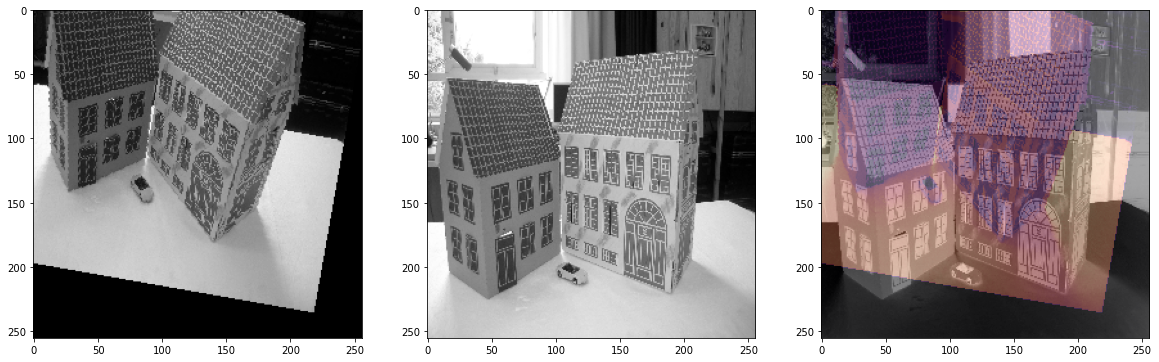

In [190]:
imA = imAr
imB = imBr
P = torch.tensor([[ np.cos(-0.174532925), -np.sin(-0.174532925), 20],
               [ np.sin(-0.174532925),  np.cos(-0.174532925),  37],
               [ 0.0000,  0.0000,  1.0000]]).float()
ar = np.arange(0,imA.shape[1])
x = np.array([ar for _ in range(imA.shape[0])]).flatten()
n = np.array([])
for i in range(imA.shape[0]):
    t = np.full((imA.shape[1]),i)
    n = np.append(n,t)
y = n.flatten()
vForm = torch.from_numpy(np.stack((x,y,np.ones_like(x)),axis=0)).float()

transMtx = tc.tensor([[imA.shape[0]//2], [imA.shape[1]//2], [0]])
t = P@(vForm-transMtx)+transMtx

# Rotation and translation
#t = P@vForm
t = t.detach().numpy()
t = np.round(t).astype(np.int)

new_im = np.zeros_like(imA)
for i in range(t.shape[1]):
    if ((0 < t[1,i] < imA.shape[0]) and (0 < t[0,i] < imA.shape[1])):
        new_im[i//imA.shape[0],i%imA.shape[1]] = imA[t[1,i],t[0,i]]
fig,ax = plt.subplots(1,3,figsize=(20,60))
ax[0].imshow(new_im,cmap='gray')
ax[1].imshow(imB,cmap='gray')
ax[2].imshow(-imB,cmap='gray')
ax[2].imshow(new_im,cmap='magma',alpha=0.35)
plt.show()

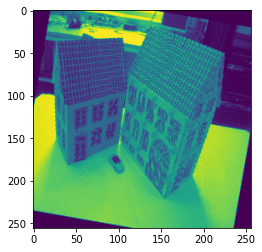

In [188]:
img4 = np.array(imAr)
(h, w) = img4.shape
(cX, cY) = (w // 2, h // 2) 
R = cv2.getRotationMatrix2D((cX, cY), -10, 1.0)
rotated = cv2.warpAffine(img4, R, (w, h))
plt.imshow(rotated)

In [63]:
import torch as tc

imA = tc.from_numpy(imAr)
imB = tc.from_numpy(imAr)
ar = np.arange(0,imA.shape[1])
x = np.array([ar for _ in range(imA.shape[0])]).flatten()
n = np.array([])
for i in range(imA.shape[0]):
    t = np.full((imA.shape[1]),i)
    n = np.append(n,t)
y = n.flatten()
vForm = tc.from_numpy(np.stack((x,y,np.ones_like(x)),axis=0)).float()

theta = 0#-1/2*np.pi
P = tc.from_numpy(np.array([
    [np.cos(theta), -np.sin(theta),0],
    [np.sin(theta),  np.cos(theta),0],
    [0,0,1]
])).float()
t = P@vForm

idx = []
for i in range(t.shape[1]):
    if not (-1 < t[0,i] < 256 and -1 < t[1,i] < 256):
        idx.append(i)
print(len(idx))
# mask = tc.ones((t.shape[1]),)
# mask[idx] = -1
# t = t[:,mask > -1]

w = LinearSpline2D(t[:2,:].T,imB)
# zeros = np.zeros((len(idx),))
# w = tc.from_numpy(np.concatenate((w,zeros)))[::10]
if (len(idx) != 0):
    w.index_fill_(0,tc.tensor(idx),0)
w = w[::10]
im_samples = imA.flatten()[::10]
samples = tc.stack([w,im_samples]).T

j, a, b = Histogram2D(samples)
print(NCC(a,tc.flip(b,[0])))

0
tensor(0.9999)


In [50]:
print(w)

tensor([0.4449, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)


In [51]:
print(im_samples)

tensor([0.4449, 0.4952, 0.5887,  ..., 0.6145, 0.6414, 0.6532],
       dtype=torch.float64)


In [83]:
tn = np.array(t)

idx = []
for i in range(tn.shape[1]):
    if not (0 < tn[0,i] < 256 and 0 < tn[1,i] < 256):
        idx.append(i)
print(idx)
tn = np.delete(tn,idx,axis=1)
print(tn)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [81]:
print(not(2 < tn[1,0] < 256))

True


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage.filters import gaussian, window
import cv2
import inspect
import math
#from scipy.stats.distributions import chi2
import torch

In [11]:
import torch as tc
def LinearSpline3D(pts,x,device='cpu',scale=[1.0, 1.0, 1.0],return_jac=False):
    scale=torch.tensor(scale,dtype=torch.float32,device=device)
    t_idx=pts.mul(1/scale).floor()
    #t_idx.detach()
    p=torch.arange(pts.size(0))
    #print(p)
    t=pts.mul(1/scale)-t_idx
    #make a cube of 2x2x2 of ones as a helper for converting indices
    ones4=torch.ones([2,2,2],dtype=torch.int32,device=device)
    #make a array of ones as a helper for converting indices
    onesp=torch.ones(t.size(0),dtype=torch.int32,device=device)
    #make a cube of 2x2x2 of indices (0-origin) as a helper for converting indices
    stride_x, stride_y, stride_z=torch.meshgrid([torch.arange(0,2,device=device), torch.arange(0,2,device=device), torch.arange(0,2,device=device)])
    #compute/transform the indices to the flatten domain
    t_idx=t_idx.flatten()
    indices=(torch.clamp(torch.einsum('a,bcd->abcd',t_idx[3*p],ones4)+torch.einsum('a,bcd->abcd',onesp,stride_x.int()),0,x.shape[1]-1)*(x.shape[2]*x.shape[3])).long()
    indices=indices+(torch.clamp(torch.einsum('a,bcd->abcd',t_idx[3*p+1],ones4)+torch.einsum('a,bcd->abcd',onesp,stride_y.int()),0,x.shape[2]-1)*(x.shape[3])).long()
    indices=indices+(torch.clamp(torch.einsum('a,bcd->abcd',t_idx[3*p+2],ones4)+torch.einsum('a,bcd->abcd',onesp,stride_z.int()),0,x.shape[3]-1)).long()
    #print(indices,indices1,indices2,indices3,"All: ",indices1+indices2+indices3,"2+3: ",indices2+indices3,"1+2: ",indices1+indices2)
    #the parameter vector for the spline (1D)
    y=torch.stack([1-t.flatten(), t.flatten()],dim=1) 
    #compute the element-wise kroenecker products 
    w=torch.sum(torch.einsum('ab,ac,ad->abcd',y[3*p,:],y[3*p+1,:],y[3*p+2,:])*x.flatten(start_dim=1)[:,indices.long()],dim=[2,3,4])
    # derivatives
    #the parameter vector for the derivative spline (1D)
    jac=None
    if(return_jac):
        dy=torch.stack([t.flatten().clone()*0-1, t.flatten().clone()*0+1],dim=1)
        wx=torch.sum(torch.einsum('ab,ac,ad->abcd',dy[3*p,:],y[3*p+1,:],y[3*p+2,:])*x.flatten(start_dim=1)[:,indices],dim=[2,3,4])
        wy=torch.sum(torch.einsum('ab,ac,ad->abcd',y[3*p,:],dy[3*p+1,:],y[3*p+2,:])*x.flatten(start_dim=1)[:,indices],dim=[2,3,4])
        wz=torch.sum(torch.einsum('ab,ac,ad->abcd',y[3*p,:],y[3*p+1,:],dy[3*p+2,:])*x.flatten(start_dim=1)[:,indices],dim=[2,3,4])
        #construct the array of jacobians
        jac=torch.stack([wx.t()/scale[0],wy.t()/scale[1],wz.t()/scale[2]],dim=2)
    return w,jac
def LinearSpline2D(pts,x,device='cpu',scale=[1.0, 1.0],return_jac=False):
    pts=torch.cat([pts[:,1].view(pts.shape[0],1)*0,pts],dim=1)
    return LinearSpline3D(pts, x.view(1,x.shape[0],x.shape[1],x.shape[2]),device)

def Histogram_LOR_LIN(vals, device='cpu'):
    rangeh = torch.ceil(vals.max() - vals.min()).long() + 4
    t_idx = vals.floor().long() + 2
    p = torch.arange(vals.size(0))
    t = vals.double() + 2 - t_idx
    # print("rangeh: ",rangeh, '\n')
    ones4 = torch.ones([2, 2], dtype=torch.int32, device=device)
    onesp = torch.ones(t.size(0), dtype=torch.int32, device=device)
    stride_x, stride_y = torch.meshgrid([torch.arange(0, 2, device=device) - 1, torch.arange(0, 2, device=device) - 1])
    t_idx = t_idx.flatten()
    indices = torch.einsum('a,bc->abc', t_idx[2 * p], ones4) * (rangeh)
    indices += torch.einsum('a,bc->abc', onesp, stride_x) * rangeh
    indices += torch.einsum('a,bc->abc', t_idx[2 * p + 1], ones4)
    indices += torch.einsum('a,bc->abc', onesp, stride_y)
    y = torch.stack([1 - t.flatten(), t.flatten()], dim=1)
    res = (torch.einsum('ab,ac->abc', y[2 * p, :], y[2 * p + 1, :]))
    # print("res: ",res.sum(),res.shape,indices.shape)
    sort_res, nid = torch.sort(indices.flatten())
    nres = res.flatten()[nid.flatten()]
    v, ids = sort_res.flatten().unique_consecutive(return_counts=True)

    val = torch.split(nres.flatten(), ids.tolist());
    hist = torch.zeros(v.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(val):
        hist[index] = value.sum()
    return hist[hist > 0], (v.flatten()%rangeh)[hist > 0],((v.flatten()/rangeh).int())[hist > 0]
def Histogram2D(vals, device='cpu'):
    rangeh = torch.ceil(vals.max() - vals.min()).long() + 4
    t_idx = vals.floor().long() + 2
    p = torch.arange(vals.size(0))
    t = vals.double() + 2 - t_idx
    # print("rangeh: ",rangeh, '\n')
    ones4 = torch.ones([2, 2], dtype=torch.int32, device=device)
    onesp = torch.ones(t.size(0), dtype=torch.int32, device=device)
    stride_x, stride_y = torch.meshgrid([torch.arange(0, 2, device=device) - 1, torch.arange(0, 2, device=device) - 1])
    t_idx = t_idx.flatten()
    indices = torch.einsum('a,bc->abc', t_idx[2 * p], ones4) * (rangeh)
    indices += torch.einsum('a,bc->abc', onesp, stride_x) * rangeh
    indices += torch.einsum('a,bc->abc', t_idx[2 * p + 1], ones4)
    indices += torch.einsum('a,bc->abc', onesp, stride_y)
    y = torch.stack([1 - t.flatten(), t.flatten()], dim=1)
    res = (torch.einsum('ab,ac->abc', y[2 * p, :], y[2 * p + 1, :]))
    # print("res: ",res.sum(),res.shape,indices.shape)
    sort_res, nid = torch.sort(indices.flatten())
    nres = res.flatten()[nid.flatten()]
    v, ids = sort_res.flatten().unique_consecutive(return_counts=True)
    val = torch.split(nres.flatten(), ids.tolist());
    hist = torch.zeros(v.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(val):
        hist[index] = value.sum()
    sort_res, nid = torch.sort(v.flatten() % rangeh)
    nres = hist.flatten()[nid.flatten()]
    va, ids = sort_res.flatten().unique_consecutive(return_counts=True)
    vala = torch.split(nres.flatten(), ids.tolist());
    hist_a = torch.zeros(va.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(vala):
        hist_a[index] = value.sum()
    sort_res, nid = torch.sort((v.flatten() / rangeh).int())
    nres = hist.flatten()[nid.flatten()]
    vb, ids = sort_res.flatten().unique_consecutive(return_counts=True)
    valb = torch.split(nres.flatten(), ids.tolist());
    hist_b = torch.zeros(vb.size(), device=device, dtype=torch.float32)
    for index, value in enumerate(valb):
        hist_b[index] = value.sum()
    return hist[hist > 0], hist_a[hist_a > 0], hist_b[hist_b > 0]

def SSD(x,device='cpu'):
    return torch.sum((x[:,0]-x[:,1])**2)

torch.Size([1, 10000])
tensor(3.1903)
tensor(1.6790)


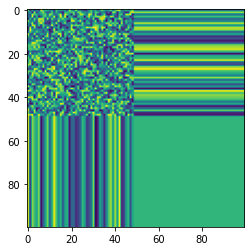

In [20]:
size = 200
grd = 100
scale = 100
img1 = tc.rand([size,size])*scale
img2 = tc.rand([size,size])*scale
# plt.figure()
# plt.imshow(img1)
x_coords,y_coords = tc.meshgrid([tc.arange(0,grd),tc.arange(0,grd)])
pts = tc.stack([x_coords.flatten(),y_coords.flatten()],dim=1)+150

samp_1,_ = LinearSpline2D(pts,img1.view(1,size,size))
print(samp_1.shape)

#for k in range(grd):
#      samp_2,_ = LinearSpline2D(pts+k,img2.view(1,size,size))
samp_2,_ = LinearSpline2D(pts,img2.view(1,size,size))

plt.figure()
plt.imshow(samp_1.view(grd,grd))
pair_1 = tc.stack([samp_1.flatten(),samp_1.flatten()],dim=1)
pair_2 = tc.stack([samp_2.flatten(),samp_1.flatten()],dim=1)

# print(SSD_LOR(pair_1))
# print(SSD_LOR(pair_2))
# print(SSD(pair_2))

histIJ,histI,histJ = Histogram2D(pair_1)

hij = tc.sum(-histIJ/histIJ.sum()*tc.log(histIJ/histIJ.sum()))
hi = tc.sum(-histI/histI.sum()*tc.log(histI/histI.sum()))
hj = tc.sum(-histJ/histJ.sum()*tc.log(histJ/histJ.sum()))
MI = hi+hj-hij
print(MI)
NMI = (hi+hj)/hij
print(NMI)

In [23]:
SSD(pair1)

tensor(0.)

In [30]:
print(tc.sum(hst),vi,vj)

tensor(10000.0010) tensor([360, 361, 360,  ..., 356, 355, 356]) tensor([-444, -444, -443,  ...,  355,  356,  356], dtype=torch.int32)


In [32]:
img1.min()

tensor(-444.5593)

In [38]:
def SSD_LOR(pair):
    hst,vi,vj = Histogram_LOR_LIN(pair)
    return tc.sum(hst*tc.abs(vi-vj)**2)